In [12]:
# Перекомпиляция модели с правильной функцией потерь
model.compile(optimizer='adam', 
              loss=tf.keras.losses.sparse_categorical_crossentropy, 
              metrics=['accuracy'])

# Проверка точности модели на обычных данных
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'Test accuracy on clean images: {test_acc:.4f}')


2024-10-11 16:29:16.559729: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.


313/313 - 0s - 867us/step - accuracy: 0.9729 - loss: 0.0883
Test accuracy on clean images: 0.9729


313/313 - 0s - 748us/step - accuracy: 0.9729 - loss: 0.0883
Test accuracy on clean images: 0.9729


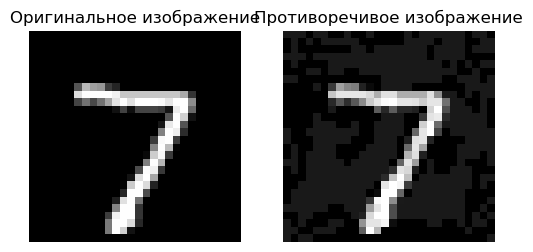

In [13]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

# Загрузка тестовых данных MNIST
(_, _), (test_images, test_labels) = mnist.load_data()
test_images = test_images / 255.0
test_images = test_images.reshape((-1, 28, 28, 1))  # Изменение формы изображений

# Загрузка обученной модели
model = tf.keras.models.load_model('mnist_model.h5')

# Перекомпиляция модели с функцией потерь sparse_categorical_crossentropy
model.compile(optimizer='adam', 
              loss=tf.keras.losses.sparse_categorical_crossentropy, 
              metrics=['accuracy'])

# Проверка точности модели на обычных данных
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'Test accuracy on clean images: {test_acc:.4f}')

# Функция для реализации FGSM атаки
def fgsm_attack(image, epsilon, gradient):
    # Применение знака градиента к изображению
    perturbed_image = image + epsilon * np.sign(gradient)
    # Обрезка значений, чтобы они оставались в пределах [0,1]
    perturbed_image = np.clip(perturbed_image, 0, 1)
    return perturbed_image

# Функция для генерации противоречивого примера
def generate_adversarial_example(model, image, label, epsilon):
    # Превращение изображения в формат, подходящий для модели
    image = tf.convert_to_tensor(image.reshape((1, 28, 28, 1)), dtype=tf.float32)
    label = tf.convert_to_tensor([label], dtype=tf.int64)

    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.sparse_categorical_crossentropy(label, prediction)

    # Получение градиента по отношению к входному изображению
    gradient = tape.gradient(loss, image)
    
    # Применение FGSM для создания противоречивого изображения
    adversarial_image = fgsm_attack(image.numpy(), epsilon, gradient.numpy())
    return adversarial_image

# Пример использования FGSM атаки
epsilon = 0.1  # Величина шума
adversarial_example = generate_adversarial_example(model, test_images[0], test_labels[0], epsilon)

# Вывод оригинального и противоречивого изображений
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(test_images[0].reshape(28, 28), cmap="gray")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Противоречивое изображение")
plt.imshow(adversarial_example.reshape(28, 28), cmap="gray")
plt.axis('off')

plt.show()


In [15]:
# Функция для генерации противоречивых примеров для всего набора данных
def generate_adversarial_dataset(model, images, labels, epsilon):
    adversarial_images = []
    for i in range(len(images)):
        # Генерация одного противоречивого примера
        adv_image = generate_adversarial_example(model, images[i], labels[i], epsilon)
        adversarial_images.append(adv_image)
    return np.array(adversarial_images)

# Генерация противоречивых примеров для тестового набора данных
adversarial_images = generate_adversarial_dataset(model, test_images, test_labels, epsilon)

# Проверка и изменение формы массива противоречивых изображений для оценки
adversarial_images = adversarial_images.reshape((-1, 28, 28, 1))

# Оценка модели на противоречивых примерах
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels, verbose=2)
print(f'Accuracy on adversarial examples: {adversarial_acc:.4f}')

313/313 - 0s - 465us/step - accuracy: 0.0865 - loss: 7.5614
Accuracy on adversarial examples: 0.0865


In [16]:
# Оценка модели на обычных данных
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'Accuracy on clean images: {test_acc:.4f}')

# Генерация противоречивых примеров для всего тестового набора
adversarial_images = generate_adversarial_dataset(model, test_images, test_labels, epsilon)

# Преобразование формы противоречивых изображений для корректной работы с моделью
adversarial_images = adversarial_images.reshape((-1, 28, 28, 1))

# Оценка модели на противоречивых примерах
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels, verbose=2)
print(f'Accuracy on adversarial examples: {adversarial_acc:.4f}')

# Вывод сравнения
print("\nСравнение результатов:")
print(f"Точность на обычных изображениях: {test_acc:.4f}")
print(f"Точность на противоречивых изображениях: {adversarial_acc:.4f}")


313/313 - 0s - 456us/step - accuracy: 0.9729 - loss: 0.0883


2024-10-11 16:33:01.560243: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.


Accuracy on clean images: 0.9729
313/313 - 0s - 471us/step - accuracy: 0.0865 - loss: 7.5614
Accuracy on adversarial examples: 0.0865

Сравнение результатов:
Точность на обычных изображениях: 0.9729
Точность на противоречивых изображениях: 0.0865


2024-10-11 16:33:23.896221: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.
